## FTP Server Crawler Scratch Work Area

- Use for basic debugging / visual checks
- Not main crawler; see `py` scripts for functions/main

In [1]:
import osgeo
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import xarray as xr
import rasterio
import glob
import shapely.speedups
import warnings
import folium
import boto3
import botocore

from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
from datetime import datetime
from tqdm import tqdm # add in progress watch
from matplotlib import pyplot as plt
from osgeo import ogr

In [2]:
# reduce to GACC region - intersect w/ boundaries
pd.set_option('display.max_columns',None)

gacc_path = '/projects/my-public-bucket/gaccRegions'
gacc_boundaries = gpd.read_file(gacc_path)
final_gacc_region = None

print(gacc_boundaries)

   OBJECTID                                           GACCName GACCUnitID  \
0         1            Southern California Coordination Center   USCAOSCC   
1         2                 Southwest Area Coordination Center    USNMSWC   
2         3                    Great Basin Coordination Center    USUTGBC   
3         4            Rocky Mountain Area Coordination Center    USCORMC   
4         5             Alaska Interagency Coordination Center    USAKACC   
5         6          Northwest Interagency Coordination Center    USORNWC   
6         7               Northern Rockies Coordination Center    USMTNRC   
7         8  Northern California Geographic Area Coordinati...   USCAONCC   
8         9                   Eastern Area Coordination Center   USWIEACC   
9        10                  Southern Area Coordination Center    USGASAC   

  GACCAbbrev                         GACCLocati  ContactPho  \
0       OSCC                      Riverside, CA  8009953473   
1       SWCC              

### To define mapping of GACC region, zip up ftp url search terms with identify zones

['USCAOSCC', 'USNMSWC', 'USUTGBC', 'USCORMC', 'USAKACC', 'USORNWC', 'USMTNRC', 'USCAONCC', 'USWIEACC', 'USGASAC']
- Mappings:
(1) 

In [4]:
# print gacc unit IDs
gacc_keys = gacc_boundaries.GACCAbbrev.tolist()
print(gacc_keys)
# print(len(gacc_keys))
random = ['me', 're', 'he', 'rfgre', 'fd', 'f', 'rf', 'gd', 'fed', 'fgd']
# print(len(random))

['OSCC', 'SWCC', 'GBCC', 'RMCC', 'AICC', 'NWCC', 'NRCC', 'ONCC', 'EACC', 'SACC']


In [5]:
# define mapping dictionary with zip 
dict_try = dict(zip(gacc_keys,random))
print(dict_try)
# check valid name line up
ftp_names = ["alaska", "calif_n", "calif_s", "eastern", "great_basin", "n_rockies", "pacific_nw", "rocky_mtn", "southern", "southwest"]
ftp_names_reordered = ["calif_s", "southwest", "great_basin", "rocky_mtn", "alaska", "pacific_nw", "n_rockies", "calif_n", "eastern", "southern"] 
assert ftp_names.sort() == ftp_names_reordered.sort(), "Extra check if any spell errors occured"

{'OSCC': 'me', 'SWCC': 're', 'GBCC': 'he', 'RMCC': 'rfgre', 'AICC': 'fd', 'NWCC': 'f', 'NRCC': 'rf', 'ONCC': 'gd', 'EACC': 'fed', 'SACC': 'fgd'}


In [9]:
# form dict 
assert len(gacc_keys) == len(ftp_names_reordered), "Cannot zip diff size lists"
gacc_name_dict = dict(zip(gacc_keys, ftp_names_reordered))
print(gacc_name_dict)

{'OSCC': 'alaska', 'SWCC': 'calif_n', 'GBCC': 'calif_s', 'RMCC': 'eastern', 'AICC': 'great_basin', 'NWCC': 'n_rockies', 'NRCC': 'pacific_nw', 'ONCC': 'rocky_mtn', 'EACC': 'southern', 'SACC': 'southwest'}


### Practice basic crawling

In [ ]:
# elem processing + crawler + sub searchers



### Extract sample files to intersect with NIFC 
- Make sure CRS matching / force espg 9311

In [25]:
# overlay with williams sample for region
# load in data for comparison 
files = glob.glob("/projects/shared-buckets/ashiklom/WesternUS/files_for_paper/*_.geojson")
data_all = pd.concat([gpd.read_file(file) for file in files],ignore_index=True)

geojson_use = True
ascending = True
default_crs = 'epsg:9311'

geojson_keyword = 'BOULDER' # 'WILLIAMS FLATS' 
all_names = data_all['Name'].tolist()
assert geojson_keyword in all_names, "Selected geojson_keyword not in GeoJson, check constants."
# read geojson
gdf = data_all[data_all['Name']==geojson_keyword].copy()
gdf = gdf.sort_values(by='t',ascending=ascending)

gdf.head()

,t,id,frp_max,frp_median,frp_mean,pixel_count,frp_sum,unique_periods,date_min,date_max,FireID,Name,Type,date_range_h,area,evt_mode,bs_mean,bs_median,EVT_SBCLS,EVT_PHYS,EVT_LF,EVT_ORDER,EVT_CLASS,geometry
6896,2015-08-23 12:00:00,0,82.64,3.865,16.886667,6.0,101.32,5.0,2015-08-23 12:00:00,2015-08-25 12:00:00,F10859,BOULDER,Wildfire,48.0,0.110267,3056.0,2.409836,2.0,Evergreen closed tree canopy,Conifer,Tree,Tree-dominated,Closed tree canopy,"POLYGON ((-114.71573 46.66116, -114.71570 46.6..."
6895,2015-08-24 00:00:00,1,75.36,3.865,14.151875,16.0,226.43,5.0,2015-08-24 00:00:00,2015-08-26 12:00:00,F10859,BOULDER,Wildfire,60.0,0.516564,3056.0,3.139373,3.0,Evergreen closed tree canopy,Conifer,Tree,Tree-dominated,Closed tree canopy,"POLYGON ((-114.72180 46.65922, -114.72202 46.6..."
6894,2015-08-24 12:00:00,2,82.64,8.150,24.958333,42.0,1048.25,6.0,2015-08-24 12:00:00,2015-08-27 00:00:00,F10859,BOULDER,Wildfire,60.0,1.823186,3056.0,3.351053,3.0,Evergreen closed tree canopy,Conifer,Tree,Tree-dominated,Closed tree canopy,"POLYGON ((-114.72552 46.65877, -114.72567 46.6..."
6893,2015-08-25 00:00:00,3,20.01,2.015,4.158000,10.0,41.58,3.0,2015-08-25 00:00:00,2015-08-26 00:00:00,F10859,BOULDER,Wildfire,24.0,0.295487,3056.0,3.583082,4.0,Evergreen closed tree canopy,Conifer,Tree,Tree-dominated,Closed tree canopy,"POLYGON ((-114.71488 46.67138, -114.71241 46.6..."
6892,2015-08-25 00:00:00,6,1.24,1.240,1.240000,1.0,1.24,1.0,2015-08-27 00:00:00,2015-08-27 00:00:00,F10859,BOULDER,Wildfire,0.0,0.005869,3056.0,3.000000,3.0,Evergreen closed tree canopy,Conifer,Tree,Tree-dominated,Closed tree canopy,"POLYGON ((-114.70576 46.65923, -114.70583 46.6..."


In [26]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
gacc_boundaries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
assert gacc_boundaries.crs == gdf.crs, "mismatch crs"

In [30]:
gdf.crs.axis_info[0].unit_name # only issue is degree 
print(type(gdf.geometry))

<class 'geopandas.geoseries.GeoSeries'>


### Intersection: manual plotting for inspection

In [52]:
# try intersect performance 
boll_results = gdf.geometry.intersects(gacc_boundaries.geometry)
opp_results = gacc_boundaries.geometry.intersects(gdf.geometry)
# print(boll_results)
# print(opp_results)

<AxesSubplot:>

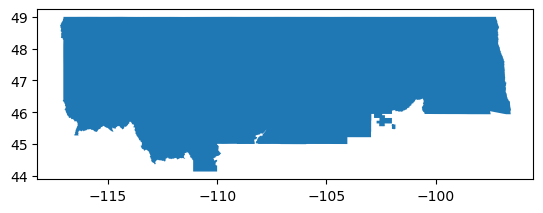

In [48]:
# reduce by iloc selection
reduced_boundaries = gacc_boundaries.iloc[[6]]
reduced_boundaries.plot()

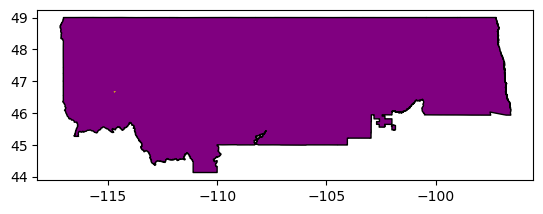

In [50]:
# plot on same axis 
# see very tiny yellow spec -> should be in rockies region
ax_undefined = False

ax = reduced_boundaries.plot(facecolor="purple", edgecolor="black")

for i in range(gdf.shape[0]):
    current = gdf.iloc[[i]]
    if ax_undefined:
        ax = current.plot(facecolor="yellow", edgecolor="black", legend=True) 
        ax_undefined = False
    else:
        current.plot(facecolor="yellow", ax=ax)

### Fixed intersect feature + unique GACC id check 

In [72]:
# try alternative intersect
intersection_retry = gpd.overlay(reduced_boundaries, gdf, how='intersection')
# intersection_retry.plot()
# print(intersection_retry.geometry)
intersection_main = gpd.overlay(gacc_boundaries, gdf, how='intersection')
# intersection_main.plot()
assert not intersection_main.empty, "Empty dataframe, no intersection"
swap_dir_main = gpd.overlay(gdf, gacc_boundaries, how='intersection')
# swap_dir_main.plot()

# extract unique GACCUnitID
# note any repeats
all_abbrevs = intersection_main.GACCAbbrev.tolist()
num_unique = len(np.unique(all_abbrevs))
assert num_unique == 1, "More than one abbrev recieved -> NIFC edgecase"